# jacobian for a vector-valued function
```
line 1: model = nn.Linear(100, 2)
# forward pass of model, i.e., chain of functions
line 2: batch = torch.randn(16, 100, requires_grad=False)
line 3: expected_output = torch.randn(16, 10, requires_grad=False)
line 4: output = model(batch)
line 5: loss = (expected_output - output).pow(2).sum()
line 6: loss.backward()
line 7: optimizer = torch.optim.SGD(model.parameters(), lr=0.001) # give weights to `optimizer` to 'learn'
line 8: optimizer.step()
```

In this notebook, I will discuss
* **how the back propagation is performed in Pytorch AutoGrad to compute the gradient? i.e., line 4-6 in the above code**

I will not discuss
* how the gradients are computed in theory
* optimization details, i.e., line 7-8 in the above code 
    + Assume we all know the general idea that parameters of neural network are updated via gradient descent algorithm after computing gradients. But there are many details or variations of gradient descent.



In [ ]:
import torch
from torch import nn
import math
import torch.nn.functional as F

## `Tensor` for AutoGrad
Relevant attributes for computing gradients
* `requires_grad`: to contral whether the gradient during the backward
* `grad_fn`: after performing operations (e.g., sin) on the input tensor, the `grad_fn` attribute would be added into the output tensor in order to calculate gradients afterward.
    + input tensor has no `grad_fn`: Since it is defined by user
    
See the following code for details.

In [ ]:
# create an input tensor
input1 = torch.linspace(0., 2. * math.pi, steps=25, requires_grad=True)

# grad_fn for output tensor
out1= torch.sin(input1)
print(out1.grad_fn)

# input tensor has no grad_fn
# print(input.grad_fn)

## Recording Tensor Operations: Computational Graph
[The official introduction](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#computational-graph) is shown below. 


> Conceptually, autograd keeps a record of data (tensors) & all executed
operations (along with the resulting new tensors) in a directed acyclic
graph (DAG) consisting of
[`Function`](https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
objects. In this DAG, leaves are the input tensors, roots are the output
tensors. By tracing this graph from roots to leaves, you can
automatically compute the gradients using the chain rule.
>
> 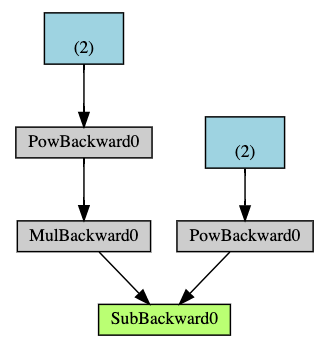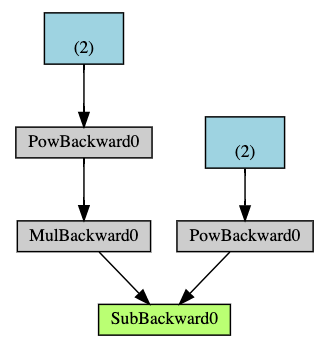
>
> In a forward pass, autograd does two things simultaneously:
> 
> - run the requested operation to compute a resulting tensor, and
> - maintain the operation’s *gradient function* in the DAG.
>
> The backward pass kicks off when ``.backward()`` is called on the DAG
root. ``autograd`` then:
> 
> - computes the gradients from each ``.grad_fn``,
> - accumulates them in the respective tensor’s ``.grad`` attribute, and
> - using the chain rule, propagates all the way to the leaf tensors.
> 
> Below is a visual representation of the DAG in our example. In the graph,
the arrows are in the direction of the forward pass. The nodes represent the backward functions
of each operation in the forward pass. The leaf nodes in blue represent our leaf tensors ``a`` and ``b``.
> 
> .. figure:: /_static/img/dag_autograd.png
> 
> <div class="alert alert-info"><h4>Note</h4><p>**DAGs are dynamic in PyTorch**
  An important thing to note is that the graph is recreated from scratch; after each
  ``.backward()`` call, autograd starts populating a new graph. This is
  exactly what allows you to use control flow statements in your model;
  you can change the shape, size and operations at every iteration if
  needed.</p></div>
> 
> Exclusion from the DAG
>
> ``torch.autograd`` tracks operations on all tensors which have their
``requires_grad`` flag set to ``True``. For tensors that don’t require
gradients, setting this attribute to ``False`` excludes it from the
gradient computation DAG.
>
> The output tensor of an operation will require gradients even if only a
single input tensor has ``requires_grad=True``.




In [ ]:
# code from the previous cell
input1 = torch.linspace(0., 2. * math.pi, steps=25, requires_grad=True)
out1= torch.sin(input1)

# perform more operations
out2 = 2 * out1
out3 = out2 + 1

#  call `backward` to calculate the gradient so the ERROR occurs
# since auto differentiation requires the final output to be a single scalar value
# The following section will explain why we cannot directly calculate jacobian for a vector valued function (i.e., tensor output)
# and how we calculate it
# out3.backward() 

# Therefore, we aggregate out3 into a scalar and call backward implicitly
out4 = out3.sum()  
out4.backward()

# Now, no problem
# after backward, intermediate result will be freed

In [ ]:
# Now, check the gradient we get for the input tensor (or variable)
input1.grad

In [ ]:
# Now, further look how `grad_fn` works to achieve this gradient
# `grad_fn` has an attribute  `next_functions`
# which stores all the backward functions for each forward operands
# For example, out3 is calculated by Add(out2 ,1)
# Therefore, `next_functions` has two elements: MulBackward0 for `out2` and None for`1` 
out3.grad_fn.next_functions

In [ ]:
# Note that MulBackward0 is exactly `out2.grad_fn`
assert out3.grad_fn.next_functions[0][0] == out2.grad_fn

grad_fn_3 = out3.grad_fn
assert grad_fn_3 == out3.grad_fn
print(grad_fn_3) # out3 <-- Add(out2 ,1)

grad_fn_2 = grad_fn_3.next_functions[0][0] # <- 2 * out1 
assert grad_fn_2 == out2.grad_fn
print('grad_fn_2:', grad_fn_2) 

grad_fn_1 = grad_fn_2.next_functions[0][0] # <- sin(input1)
assert grad_fn_1 == out1.grad_fn
print('grad_fn_1:', grad_fn_1)

grad_fn_0 = grad_fn_1.next_functions[0][0]  # <- accumulate
assert input1.grad_fn is None
print('grad_fn_0:',grad_fn_0)

## Vector-Jacobian Product
In the previous cell, we cannot calculate jacobian. In order to do this, We need to explicitly pass a gradient argument in `out3.backward()` which is a tensor of the same shape as out3. For example, we can pass `1` to represent the gradient of out3 w.r.t. itself: `out3.backward(gradient=torch.ones(out3.shape))`. The gradient of the input tensor will equal to sum up `out3` into a scalar. To emphasize the main point,

**`AutoGrad` works using Vector-Jacobian Product**

This is exactly what happens during training a neural network where **any intermediate gradient in the model** is jacobian, **Loss gradient** is the vector.

Specifically, a forward pass during training consists of:
* function1: y=f(x) (e.g.,multi-class classifiers C):
    + Forward: n-dim input x -> m-dim output y
    + Backward: get `Jacobian(y w.r.t x)`  -> **Model output gradient**
* function2: loss fn L(y): 
    + Forward: m-dim output -> scalar value
    + Backward: get the `GradientVector(L w.r.t y)`, -> **Loss gradient**
* Matrix Multiplication: Jacobian(y w.r.t x) * GradientVector(L w.r.t y)
    + Chain rule: get grad(L w.r.t x) -> **Loss gradient**
        
        

[The official introduction](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html) is shown below.

> ## Vector Calculus using ``autograd``
> Mathematically, if you have a vector valued function
$\vec{y}=f(\vec{x})$, then the gradient of $\vec{y}$ with
respect to $\vec{x}$ is a Jacobian matrix $J$:
>
> \begin{align}J
     =
      \left(\begin{array}{cc}
      \frac{\partial \bf{y}}{\partial x_{1}} &
      ... &
      \frac{\partial \bf{y}}{\partial x_{n}}
      \end{array}\right)
     =
     \left(\begin{array}{ccc}
      \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{1}}{\partial x_{n}}\\
      \vdots & \ddots & \vdots\\
      \frac{\partial y_{m}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
      \end{array}\right)\end{align}
>
> Generally speaking, ``torch.autograd`` is an engine for computing
vector-Jacobian product. That is, given any vector $\vec{v}$, compute the product
$J^{T}\cdot \vec{v}$
>
> If $\vec{v}$ happens to be the gradient of a scalar function $l=g\left(\vec{y}\right)$:
>
> \begin{align}\vec{v}
   =
   \left(\begin{array}{ccc}\frac{\partial l}{\partial y_{1}} & \cdots & \frac{\partial l}{\partial y_{m}}\end{array}\right)^{T}\end{align}
>
> then by the chain rule, the vector-Jacobian product would be the
gradient of $l$ with respect to $\vec{x}$:
>
> \begin{align}J^{T}\cdot \vec{v}=\left(\begin{array}{ccc}
      \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{1}}\\
      \vdots & \ddots & \vdots\\
      \frac{\partial y_{1}}{\partial x_{n}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
      \end{array}\right)\left(\begin{array}{c}
      \frac{\partial l}{\partial y_{1}}\\
      \vdots\\
      \frac{\partial l}{\partial y_{m}}
      \end{array}\right)=\left(\begin{array}{c}
      \frac{\partial l}{\partial x_{1}}\\
      \vdots\\
      \frac{\partial l}{\partial x_{n}}
      \end{array}\right)\end{align}
>
> This characteristic of vector-Jacobian product is what we use in the above example;
``external_grad`` represents $\vec{v}$.

In [ ]:
import torch
x = torch.Tensor([1.,2.,3.])
x.requires_grad = True
y = x * 2
print(y)

# we have to give the vector for jacobian calculation
# i.e., set manual gradient of the tensor which is backward from
v = torch.tensor([1.,0.1,0.01], dtype=torch.float)
y.backward(gradient=v)
print(x.grad)
print(x.grad_fn)
print(x.is_leaf)

In [ ]:
# How a batch of samples （e.g., [x1, x2]） accumulate gradients? 
import torch
# parameters
w = torch.Tensor([1.,2.,3.])
print('Original w grad:', w.grad)
w.requires_grad=True
# we create `x` containing two examples, each has 3-dimensional features
x1 = torch.Tensor([1.,2.,3.])
x2 = torch.Tensor([4.,5.,6.])

y = x1 * w
loss = y.sum()
loss.backward()
print('w grad with x1:', w.grad)

y = x2 * w
loss = y.sum()
w.grad = None
loss.backward()
print('w grad with x2:', w.grad)


# The gradients will be summed up in the batch dimension
x = torch.Tensor([[1.,2.,3.],
                  [4.,5.,6.]])
y = x * w
loss = y.sum()
w.grad = None
loss.backward()
print('mini-batch gradient of parameters with x1 and x2:', w.grad)

## `nn.Module` for AutoGrad
Neural network cosists of a stack of operations on data input tensors and model parameter tensors (This is explained by [my previous post](https://www.kaggle.com/sergioli212/neural-network-pytorch-module)). `nn.Module` has the basic implementation to record the model parameters and operations in high level. Then, these parameter tensors use `AutoGrad` to manage the gradient track so that parameters could be updated once they get their gradients from `backward`. 

In a nutshell, 

**All the neural networks in Pytorch are built upon the parent class `nn.Module`**, further, **in a nested way**

The following code cell demonstrates how model parameters are used by `Module` and how they are **nested**

In [ ]:
class TinyModel(nn.Module):
    def __init__(self):
        super(TinyModel, self).__init__()
        
        self.layer1 = nn.Linear(1000, 100)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(100, 10)
        
    def forward(self, x):
        return self.layer2(self.relu(self.layer1(x)))

model = TinyModel()


# `weight` -> `torch.nn.parameter.Parameter`
# `Parameter` is the sub-class of `Tensor`
print(type(model.layer2.weight))
# These `Tensor`s are leaf nodes. So they do not have `grad_fn`
print(model.layer2.weight.grad_fn)
# but slice is considered as differentiable function
print(model.layer2.weight[0][:10]) 
# no grad before `backward`
print(model.layer2.weight.grad)

In [ ]:
# forward pass of model, i.e., chain of functions
batch = torch.randn(16, 1000, requires_grad=False)
expected_output = torch.randn(16, 10, requires_grad=False)
output = model(batch)
loss = (expected_output - output).pow(2).sum()

# backward pass
loss.backward()

## Other common practice when using `AutoGrad`
1. [Turn `Autograd` off](#Turn-Autograd-off)
2. [Backward hook](#Backward-hook)
3. [Compared to Tensorflow backward](#Compared-to-Tensorflow-backward)

### Turn `Autograd` off

In [ ]:

# with Autograd
a = torch.ones(2, 3, requires_grad=True)
b = torch.ones(2, 3, requires_grad=True)
c = a * b
print(c)

# turn Autograd off only when both `a` and `b` are off
a.requires_grad = False
c = a * b
# print(c.grad_fn.next_functions) # it only has one `grad_fn` for `b` now 
print(c)


a.requires_grad = False
b.requires_grad = False
c = a * b
print(c) # no `grad_fn`

a.requires_grad = True
b.requires_grad = True
# turn Autograd off temporarily using `no_grad()` context manager
# note that in contrast to `no_grad()`, we can use `enable_grad()` to turn on
with torch.no_grad():
    c = a + b
print(c)

c = a + b
print(c)

# turn Autograd off in function using `no_grad` decorator
@torch.no_grad()
def add_tensors(x, y):
    return x + y


# copy tensor w.o computation history using `detach()`
# this happens mostly for needs to implicit conversion
# between tensor and numpy array in libraries like matplotlib
x = torch.randn(5, requires_grad=True)
y = x.detach()
print(x)
print(y)

### Backward hook

While the gradients of model parameters could be accessed directly via `grad` attribute, sometimes we also need to access the gradient of model/layer input or output which provide information for a lot of use cases like visualization, or, in my case, crafting adversarial examples.

Some Resources:  

https://stackoverflow.com/questions/65011884/understanding-backward-hooks

[Gradients from hook triggered by backward and autograd are different](https://discuss.pytorch.org/t/gradients-from-hook-triggered-by-backward-and-autograd-are-different/68209)

https://www.kaggle.com/sironghuang/understanding-pytorch-hooks


In [ ]:
class TestModule(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        internal_size = 5
        self.linear1 = nn.Linear(input_size, internal_size)
        self.linear2 = nn.Linear(internal_size, output_size)

    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x
model = TestModule(10,2)

In [ ]:
# model = TestModule(4, 3)


# def print_hook(module: nn.Module, _inputs, _outputs):
#     print('hook triggered on', module)


# for module in model.modules():
#     if isinstance(module, nn.Linear):
#         module.register_full_backward_hook(print_hook)
#         print('added hook to', module)

# x, y = torch.rand(size=(20, 4)), torch.randint(low=0, high=3, size=(20,))
# loss = F.cross_entropy(model(x), y)

# print('backward started')
# loss.backward()
# print('backward complete')

In [ ]:
# # embedding layer
# embedding_layer = nn.Embedding(1000, 768)
# embedding_layer(torch.randint(0, embedding_layer.weight.shape[0], (8, 33))) # no grad_in, only grad_out for input embeddings


# # linear layer
# L = nn.Linear(5, 10)
# A = nn.Sequential(L, nn.Linear(10, 20), nn.Linear(20, 1))

# out_grads = []
# in_grads = []
# def grad_hook(module, grad_in, grad_out):
#     in_grads.append(grad_in[0])
#     out_grads.append(grad_out[0])

# emb_hook = L.register_full_backward_hook(grad_hook)
# from torch.autograd import Variable
# X = Variable(torch.randn(3, 5), requires_grad=True)
# loss = A(X).sum()
# loss.backward()
# # print(in_grads[0].shape)
# # print(out_grads[0].shape)

# # grad_in: (3, 5), grad_out: (3, 10)
# #  grad_in: (50000, 768); grad_out: (8, 33, 768)

### Compared to Tensorflow backward

A simple example is given below. I have not investigated the details of Tensorflow `autodiff` and hope to do more work when I am available.

In [ ]:

import tensorflow as tf
#  the example here computes the ouput of z w.r.t model parameters.
input_dim = 2
output_dim = 1
num_example = 1


tf.random.set_seed(22)
W = tf.Variable(tf.random.normal((output_dim, input_dim)))
X = tf.constant(tf.random.normal((input_dim, num_example)))
print('W:', W.numpy())
print('X:', X.numpy())

 
with  tf.GradientTape() as tape:
    z = tf.matmul(W, X)
    print('z:', z.numpy())

dz_dW = tape.gradient(z, W)
dz_dW

# Normally, the input sample has more than 1 example. Let's take `num_example=2`. 
num_example = 2


tf.random.set_seed(22)
W = tf.Variable(tf.random.normal((output_dim, input_dim)))
X = tf.constant(tf.random.normal((input_dim, num_example)))
print('W:', W.numpy())
print('X:', X.numpy())

 
with  tf.GradientTape() as tape:
    z = tf.matmul(W, X)
    print('z:', z.numpy())

dz_dW = tape.gradient(z, W)
dz_dW

# The gradients w.r.t `W` we got are summed from two examples. 
# For example, since the gradient w.r.t w1 or `W[0]` equals to x1 or `X[0]`, 
# here we got 0.2138209(= -0.12328745+0.33710834). 
# However, during the backward pass of neural network, 
# we average the gradients across training examples(considering the learning rate, it doesnot necessarily need to be averaged). 
# Some common misunderstanding may be found [here](https://datascience.stackexchange.com/questions/33489/why-averaging-the-gradient-works-in-gradient-descent).
# However, if the function output is a vector, it would compute the gradients of vector's sum. 
# Check [`jacobian`](https://www.tensorflow.org/api_docs/python/tf/GradientTape#jacobian) for computing autodiff for each element in the output vector.

w  = tf.Variable([1.0, 2.0])
x  = tf.Variable([4.0, 6.0])
with tf.GradientTape() as tape:
  y = w * x

tape.gradient(y, w)

## Reference
* [Pytorch AutoGrad Guide](https://pytorch.org/docs/stable/autograd.html#default-grad-layouts)
* [Github: Autograd Tutorial](https://github.com/HIPS/autograd/blob/master/docs/tutorial.md)